### Importing Required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Libraries for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
#Libraries for handling Imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Loading the Dataset and Basic Understanding 

In [2]:
# Loading the dataset
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Dropping columns with no useful information
df=df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


📊 Inference:
- The data has two categorical variables: 'Geography' and 'Gender'
- We will be required to encode them for further processing

In [5]:
# Checking for missing values
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

📊 Inference:
- There are no null values in the dataset!
- Therefore no imputation required

In [6]:
# Checking for Outliers
def continuous_plot(column):
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    sns.histplot(x=column,hue="Exited",data=df,kde=True,palette="Set2")
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=15)

    plt.subplot(1,2,2)
    sns.boxplot(df["Exited"],df[column],palette="Set2")
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=15)
    plt.tight_layout()
    plt.show()

C:\Users\PRIYANSHU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


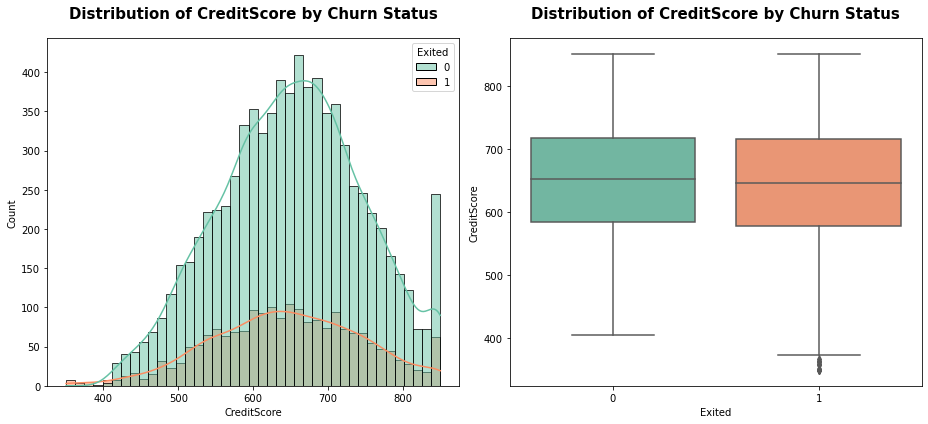

C:\Users\PRIYANSHU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


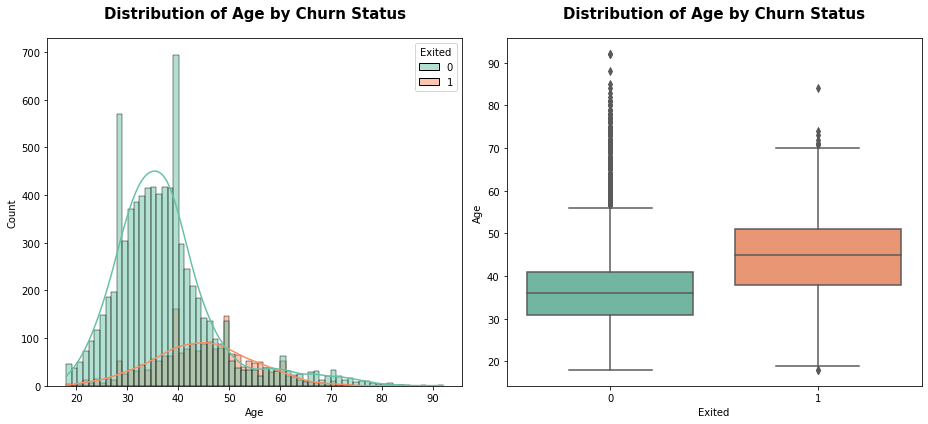

C:\Users\PRIYANSHU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


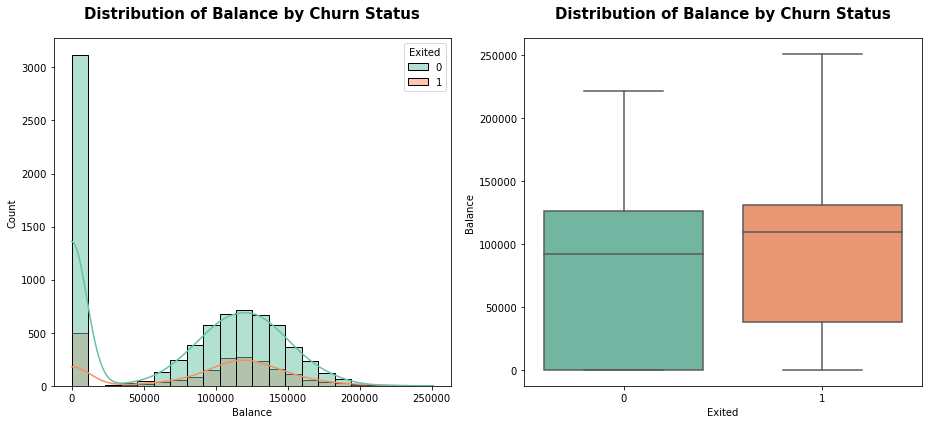

C:\Users\PRIYANSHU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


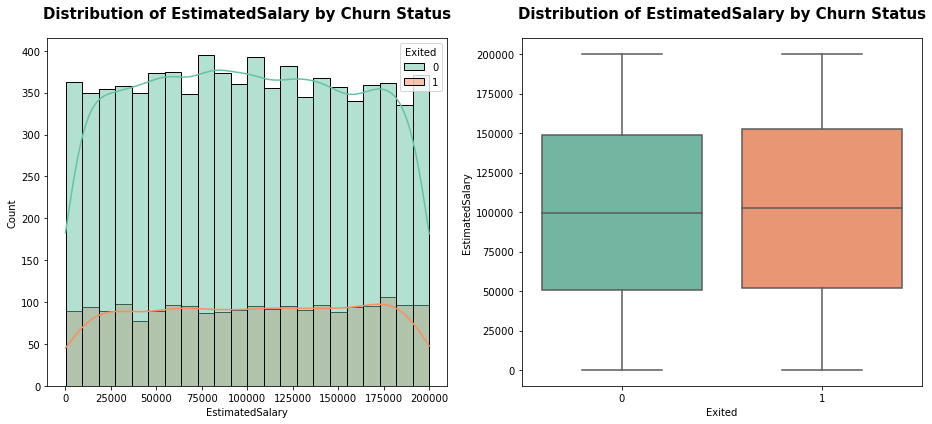

In [7]:
for col in df[['CreditScore', 'Age', 'Balance','EstimatedSalary']]:
    continuous_plot(col)

📊 Inference:
1. Age: 
- The distribution is right skewed because of presence of outliers which can lead to overfitting in model.
- To overcome this right-skewed distribution we can use log normal transformation technique to bring a normal distribution.

In [8]:
def countplot(column):
    plt.figure(figsize=(14,5))
    ax = sns.countplot(x=column, data=df, hue="Exited",palette="Set2")
    for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=15)
        
    plt.title(f"Customer Churned by {column}",fontweight="black",size=20,pad=20)
    plt.show()

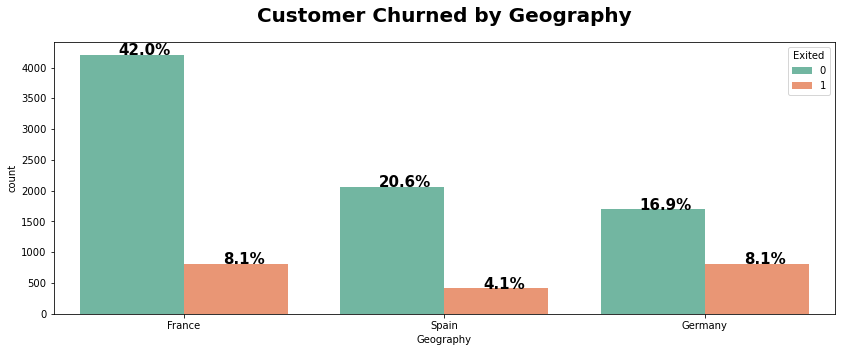

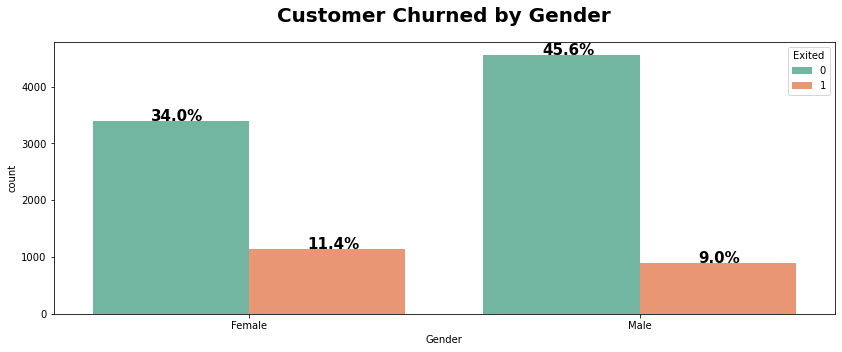

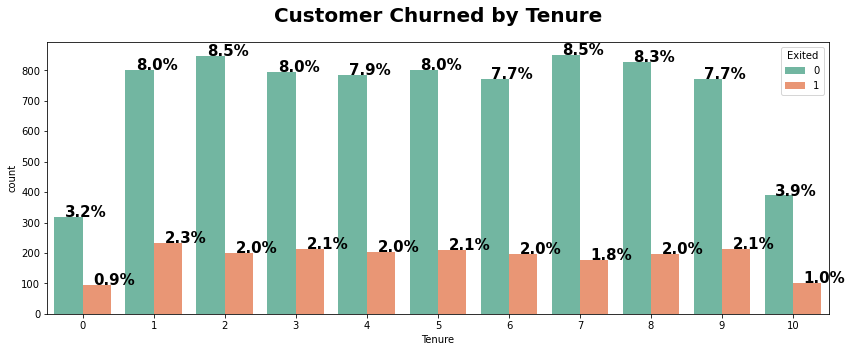

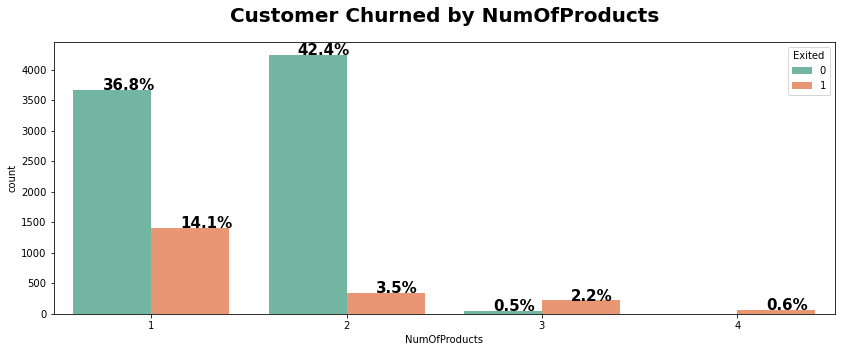

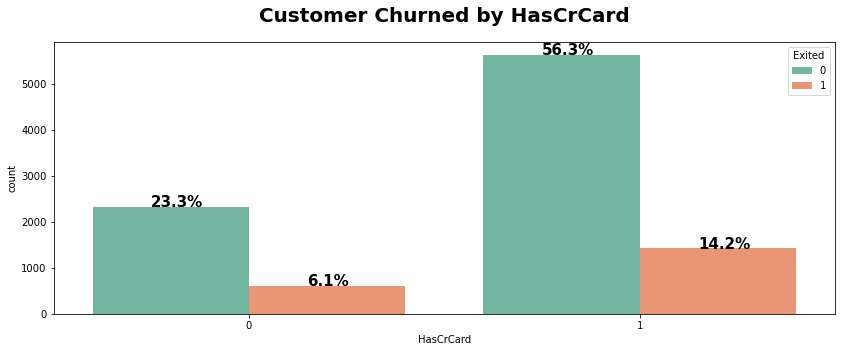

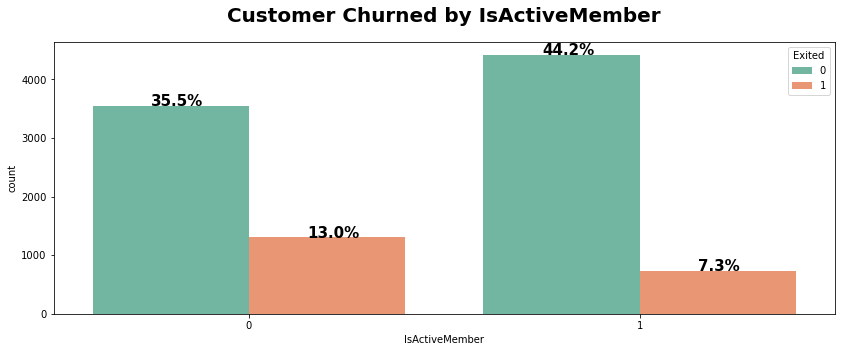

In [9]:
for col in df[['Geography', 'Gender', 'Tenure', 'NumOfProducts','HasCrCard','IsActiveMember']]:
    countplot(col)

📊 Inference:
- There are almost equal customers from Spain & Germany, but the Churn rate is almost double in Germany when compared with spain.
- The churned probabillity is more for Feamle Customers compared to male customers.
- There is very high churn rate in customers having 1 product or more than 2 products.
- The churn rate % in not active customers is almost double compared to active customers.

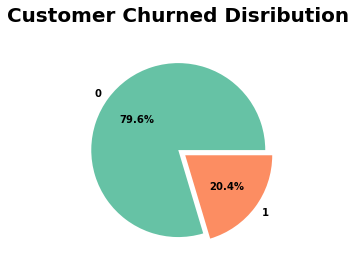

In [10]:
# Visualizing Target Variable
count = df["Exited"].value_counts()
plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("Set2"),
        textprops={"fontweight":"black"},explode=[0,0.1])
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)
plt.show()

📊 Inference:
- There is a huge class imbalance
- To overcome the imbalance, we will perform over-sampling technique

In [11]:
# Encoding categorical Variables for further analysis
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['Geography']= label_encoder.fit_transform(df['Geography'])
df['Gender']= label_encoder.fit_transform(df['Gender'])  
# df['Geography'].unique()
# df['Gender'].unique()

In [12]:
df.head()
# The categorical variables have been encoded

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [13]:
# Performing Principal Component Analysis to infer the best features for the model

# Extracting features and target variable
X = df.drop('Exited', axis=1)
y = df['Exited']

# Data Scaling: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data Dimensionality Reduction: PCA
pca = PCA(n_components=6)  # You can choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Feature Selection: Chi-Square
best_features = SelectKBest(score_func=chi2, k=10)  # Choose appropriate number of features
selected_features = best_features.fit(X, y)
X_selected = selected_features.transform(X)


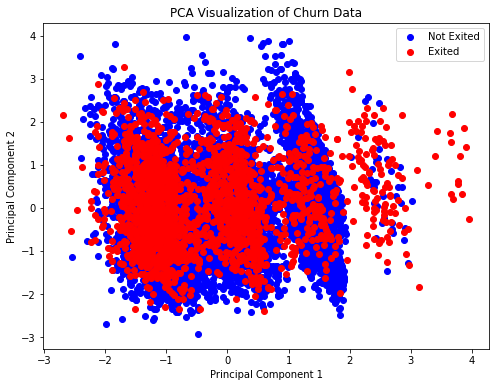

In [14]:
# Creating a scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Not Exited')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', label='Exited')
plt.title('PCA Visualization of Churn Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

- The data is first standardized using StandardScaler to have zero mean and unit variance. 
- Then, PCA is applied to reduce the dimensionality to 6 components for visualization purposes. 
- The scatter plot is created to visualize the data points in the reduced feature space. Data points belonging to different classes ('Not Exited' and 'Exited') are plotted

In [15]:
# Since Variable 'Age' has many outliers, performing transformation by Binning
df['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [16]:
age_bins = [0, 30, 40, 50, 60, 70, np.inf]
labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=labels)
# age_bins = [0, 25, 35, 50, 75, 100]
# df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins)
cross_table01 = pd.crosstab(df['AgeGroup'], df['Exited'])
print(cross_table01)

Exited       0    1
AgeGroup           
<30       1820  148
30-40     3913  538
40-50     1532  788
50-60      349  448
60-70      227  104
70+        122   11


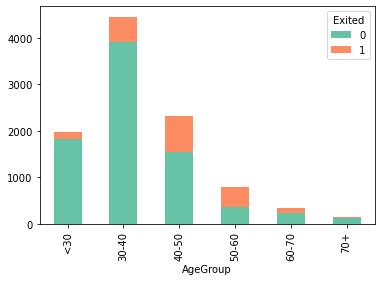

In [17]:
# Creating barplot
pl = cross_table01.plot(kind="bar", stacked=True)

In [18]:
#Creating heatmap to find correlation within dataset
correlation_matrix= df.corr()
correlation_matrix

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.007888,-0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Geography,0.007888,1.000000,0.004719,0.022812,0.003739,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943
Gender,-0.002857,0.004719,1.000000,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512
Age,-0.003965,0.022812,-0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.003739,0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.069408,0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,0.003972,-0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.008523,0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.006724,0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.001369,-0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


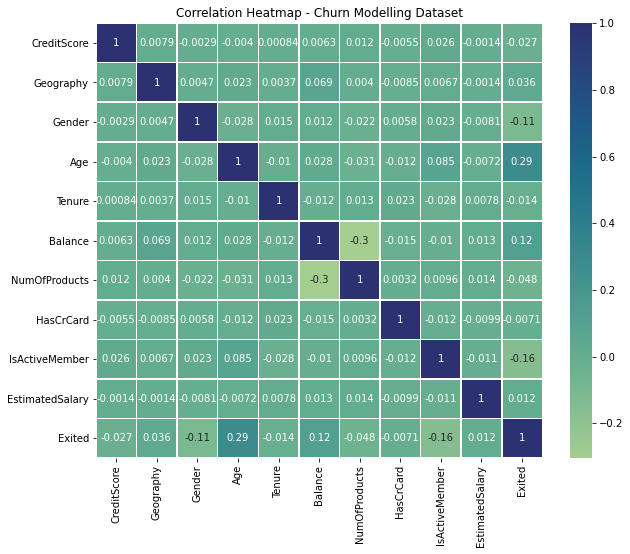

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5)
plt.title('Correlation Heatmap - Churn Modelling Dataset')
plt.show()

### Using SMOTE for imbalanced data

In [20]:
# The target Variable 
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- The target variable is imbalanced since it has improportional values for the categories
- This will lead to biased results and the model will perform low on performance metrics
- We shall implement various techniques to deal with this

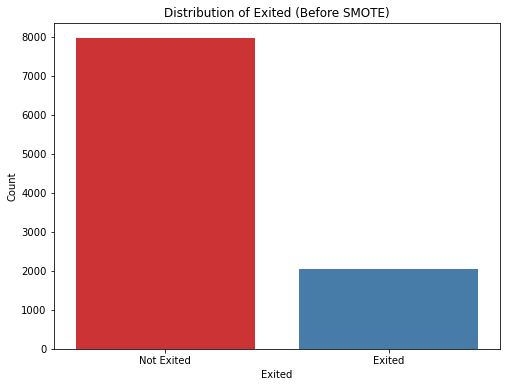

In [21]:
# Visualizing the distribution of 'Exited' before SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Exited'], palette='Set1')
plt.title('Distribution of Exited (Before SMOTE)')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Exited', 'Exited'])
plt.show()

In [22]:
# Handling Imbalanced Data: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

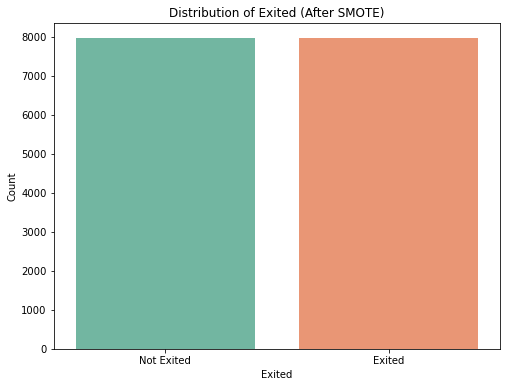

In [23]:
# Visualize the distribution of 'Exited' after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Distribution of Exited (After SMOTE)')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Exited', 'Exited'])
plt.show()

In [24]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [25]:
# Count the distribution of 'Exited' after SMOTE
exited_counts = np.bincount(y_resampled)
exited_counts

array([7963, 7963], dtype=int64)